In [1]:
import pandas as pd
df = pd.read_csv('australian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:59:56.944000,VER,1,0 days 00:01:27.458000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:18.462000,...,True,Red Bull Racing,0 days 00:58:29.232000,2024-03-24 04:03:12.430,1,1.0,False,NaN,False,False
1,0 days 01:01:21.043000,VER,1,0 days 00:01:24.099000,2.0,1.0,NaN,NaN,0 days 00:00:29.623000,0 days 00:00:18.375000,...,True,Red Bull Racing,0 days 00:59:56.944000,2024-03-24 04:04:40.142,1,2.0,False,NaN,False,True
2,0 days 01:02:44.158000,VER,1,0 days 00:01:23.115000,3.0,1.0,NaN,NaN,0 days 00:00:28.793000,0 days 00:00:18.573000,...,True,Red Bull Racing,0 days 01:01:21.043000,2024-03-24 04:06:04.241,1,2.0,False,NaN,False,True
3,0 days 01:04:24.523000,VER,1,NaN,4.0,1.0,NaN,0 days 01:04:24.613000,0 days 00:00:28.756000,0 days 00:00:18.353000,...,True,Red Bull Racing,0 days 01:02:44.158000,2024-03-24 04:07:27.356,1,19.0,False,NaN,False,False
4,0 days 01:00:06.790000,GAS,10,0 days 00:01:37.304000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:18.854000,...,True,Alpine,0 days 00:58:29.232000,2024-03-24 04:03:12.430,1,17.0,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0 days 02:13:21.370000,PIA,81,0 days 00:01:20.199000,54.0,3.0,NaN,NaN,0 days 00:00:27.903000,0 days 00:00:17.756000,...,False,McLaren,0 days 02:12:01.171000,2024-03-24 05:16:44.369,1,4.0,False,NaN,False,True
994,0 days 02:14:42.124000,PIA,81,0 days 00:01:20.754000,55.0,3.0,NaN,NaN,0 days 00:00:28.154000,0 days 00:00:17.949000,...,False,McLaren,0 days 02:13:21.370000,2024-03-24 05:18:04.568,1,4.0,False,NaN,False,True
995,0 days 02:16:02.481000,PIA,81,0 days 00:01:20.357000,56.0,3.0,NaN,NaN,0 days 00:00:27.947000,0 days 00:00:17.927000,...,False,McLaren,0 days 02:14:42.124000,2024-03-24 05:19:25.322,1,4.0,False,NaN,False,True
996,0 days 02:17:27.736000,PIA,81,0 days 00:01:25.255000,57.0,3.0,NaN,NaN,0 days 00:00:28.222000,0 days 00:00:18.192000,...,False,McLaren,0 days 02:16:02.481000,2024-03-24 05:20:45.679,126,4.0,False,NaN,False,False


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 58  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2               7.0          19.000000   
1    ALO              2              18.0          19.333333   
2    BOT              2               9.0          19.000000   
3    GAS              2              18.0          19.000000   
4    HAM              1               8.0           8.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0            0.0000          0.105263         0.894737  
1            0.0000          0.413793         0.586207  
2            0.0000          0.140351         0.859649  
3            0.0000          0.298246         0.701754  
4            0.4375          0.000000         0.562500  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,6.0,0 days 01:07:03.041000,NaN,MEDIUM,6.0,1.0
1,ALB,7.0,NaN,0 days 01:07:20.614000,HARD,1.0,2.0
2,ALB,27.0,0 days 01:36:52.888000,NaN,HARD,21.0,2.0
3,ALB,28.0,NaN,0 days 01:37:10.502000,HARD,1.0,3.0
4,ALO,17.0,0 days 01:22:24.439000,NaN,HARD,18.0,1.0
...,...,...,...,...,...,...,...
69,ZHO,1.0,NaN,0 days 00:58:37.885000,SOFT,1.0,1.0
70,ZHO,6.0,0 days 01:07:06.691000,NaN,SOFT,6.0,1.0
71,ZHO,7.0,NaN,0 days 01:07:25.636000,HARD,2.0,2.0
72,ZHO,35.0,0 days 01:48:08.338000,NaN,HARD,30.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,7.0,19.000000,0.000000,0.105263,0.894737
1,ALO,2,18.0,19.333333,0.000000,0.413793,0.586207
2,BOT,2,9.0,19.000000,0.000000,0.140351,0.859649
3,GAS,2,18.0,19.000000,0.000000,0.298246,0.701754
4,HAM,1,8.0,8.000000,0.437500,0.000000,0.562500
5,HUL,2,18.0,19.333333,0.000000,0.310345,0.689655
6,LEC,2,10.0,19.333333,0.000000,0.155172,0.844828
7,MAG,2,8.0,19.000000,0.000000,0.122807,0.877193
8,NOR,2,15.0,19.333333,0.000000,0.241379,0.758621
9,OCO,3,10.0,14.250000,0.000000,0.157895,0.842105


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,857


In [9]:
df['Driver'].value_counts()


,count
Driver,
SAI,51
HUL,51
ALO,51
ALB,50
NOR,50
GAS,50
MAG,50
RIC,50
LEC,50


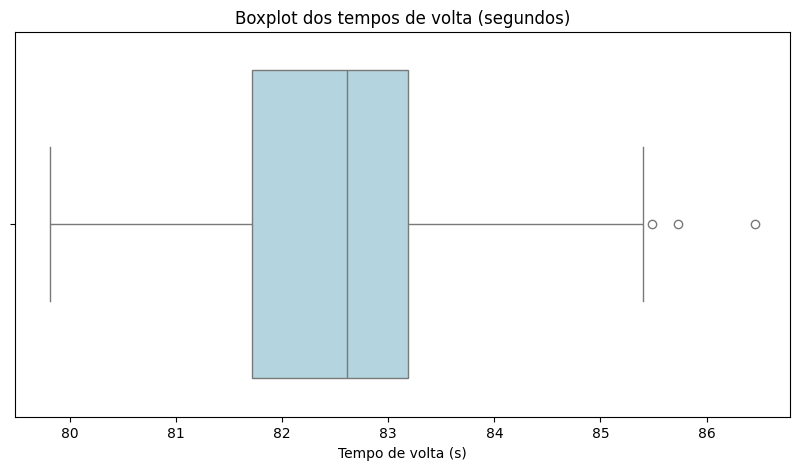

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


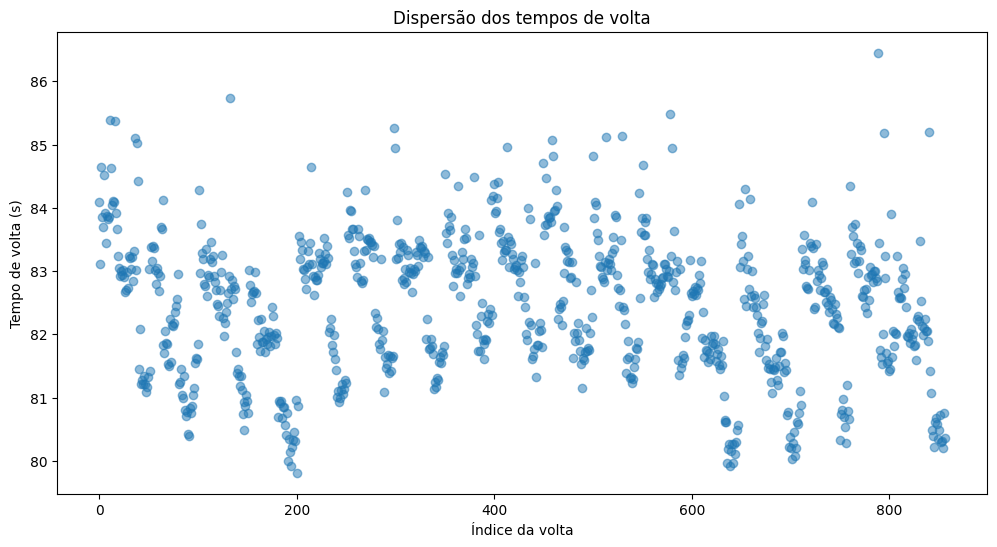

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


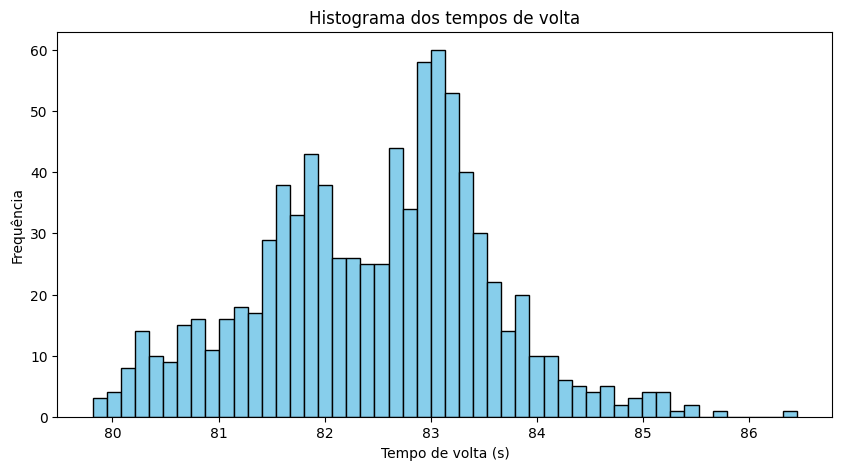

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


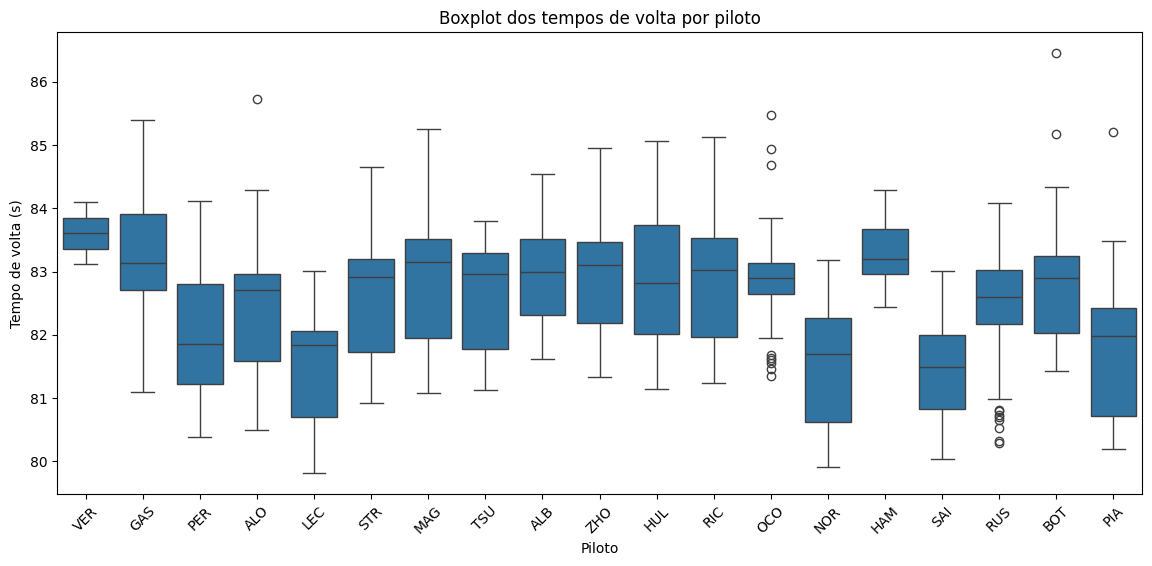

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
LEC   0 days 00:01:19.813000
NOR   0 days 00:01:19.915000
SAI   0 days 00:01:20.031000
PIA   0 days 00:01:20.199000
RUS   0 days 00:01:20.284000
PER   0 days 00:01:20.388000
ALO   0 days 00:01:20.493000
STR   0 days 00:01:20.930000
MAG   0 days 00:01:21.082000
GAS   0 days 00:01:21.090000
TSU   0 days 00:01:21.134000
HUL   0 days 00:01:21.145000
RIC   0 days 00:01:21.239000
ZHO   0 days 00:01:21.327000
OCO   0 days 00:01:21.354000
BOT   0 days 00:01:21.422000
ALB   0 days 00:01:21.618000
HAM   0 days 00:01:22.444000
VER   0 days 00:01:23.115000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Australia'
race_date = '2024-03-24'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,50,82.968580,0.768674,81.618,84.536,83.0000,2.918,2024,Australia,2024-03-24
1,ALO,51,82.431784,1.010906,80.493,85.730,82.7040,5.237,2024,Australia,2024-03-24
2,BOT,48,82.811312,0.973072,81.422,86.453,82.8930,5.031,2024,Australia,2024-03-24
3,GAS,50,83.146420,1.188657,81.090,85.397,83.1300,4.307,2024,Australia,2024-03-24
4,HAM,12,83.309667,0.612363,82.444,84.295,83.2055,1.851,2024,Australia,2024-03-24
5,HUL,51,82.864216,1.004523,81.145,85.070,82.8230,3.925,2024,Australia,2024-03-24
6,LEC,50,81.491060,0.912012,79.813,83.014,81.8410,3.201,2024,Australia,2024-03-24
7,MAG,50,82.887440,0.984521,81.082,85.255,83.1570,4.173,2024,Australia,2024-03-24
8,NOR,50,81.551980,0.966931,79.915,83.183,81.7025,3.268,2024,Australia,2024-03-24
9,OCO,48,82.897146,0.823982,81.354,85.483,82.9050,4.129,2024,Australia,2024-03-24


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,50,82.968580,0.768674,81.618,84.536,83.0000,2.918,2024,Australia,2024-03-24,57.0,True
1,ALO,51,82.431784,1.010906,80.493,85.730,82.7040,5.237,2024,Australia,2024-03-24,58.0,True
2,BOT,48,82.811312,0.973072,81.422,86.453,82.8930,5.031,2024,Australia,2024-03-24,57.0,True
3,GAS,50,83.146420,1.188657,81.090,85.397,83.1300,4.307,2024,Australia,2024-03-24,57.0,True
4,HAM,12,83.309667,0.612363,82.444,84.295,83.2055,1.851,2024,Australia,2024-03-24,16.0,False
5,HUL,51,82.864216,1.004523,81.145,85.070,82.8230,3.925,2024,Australia,2024-03-24,58.0,True
6,LEC,50,81.491060,0.912012,79.813,83.014,81.8410,3.201,2024,Australia,2024-03-24,58.0,True
7,MAG,50,82.887440,0.984521,81.082,85.255,83.1570,4.173,2024,Australia,2024-03-24,57.0,True
8,NOR,50,81.551980,0.966931,79.915,83.183,81.7025,3.268,2024,Australia,2024-03-24,58.0,True
9,OCO,48,82.897146,0.823982,81.354,85.483,82.9050,4.129,2024,Australia,2024-03-24,57.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,7.0,19.000000,0.000000,0.105263,0.894737
1,ALO,2,18.0,19.333333,0.000000,0.413793,0.586207
2,BOT,2,9.0,19.000000,0.000000,0.140351,0.859649
3,GAS,2,18.0,19.000000,0.000000,0.298246,0.701754
4,HAM,1,8.0,8.000000,0.437500,0.000000,0.562500
5,HUL,2,18.0,19.333333,0.000000,0.310345,0.689655
6,LEC,2,10.0,19.333333,0.000000,0.155172,0.844828
7,MAG,2,8.0,19.000000,0.000000,0.122807,0.877193
8,NOR,2,15.0,19.333333,0.000000,0.241379,0.758621
9,OCO,3,10.0,14.250000,0.000000,0.157895,0.842105


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,50,82.968580,0.768674,81.618,84.536,83.0000,2.918,2024,Australia,2024-03-24,57.0,True,2,7.0,19.000000,0.000000,0.105263,0.894737
1,ALO,51,82.431784,1.010906,80.493,85.730,82.7040,5.237,2024,Australia,2024-03-24,58.0,True,2,18.0,19.333333,0.000000,0.413793,0.586207
2,BOT,48,82.811312,0.973072,81.422,86.453,82.8930,5.031,2024,Australia,2024-03-24,57.0,True,2,9.0,19.000000,0.000000,0.140351,0.859649
3,GAS,50,83.146420,1.188657,81.090,85.397,83.1300,4.307,2024,Australia,2024-03-24,57.0,True,2,18.0,19.000000,0.000000,0.298246,0.701754
4,HAM,12,83.309667,0.612363,82.444,84.295,83.2055,1.851,2024,Australia,2024-03-24,16.0,False,1,8.0,8.000000,0.437500,0.000000,0.562500
5,HUL,51,82.864216,1.004523,81.145,85.070,82.8230,3.925,2024,Australia,2024-03-24,58.0,True,2,18.0,19.333333,0.000000,0.310345,0.689655
6,LEC,50,81.491060,0.912012,79.813,83.014,81.8410,3.201,2024,Australia,2024-03-24,58.0,True,2,10.0,19.333333,0.000000,0.155172,0.844828
7,MAG,50,82.887440,0.984521,81.082,85.255,83.1570,4.173,2024,Australia,2024-03-24,57.0,True,2,8.0,19.000000,0.000000,0.122807,0.877193
8,NOR,50,81.551980,0.966931,79.915,83.183,81.7025,3.268,2024,Australia,2024-03-24,58.0,True,2,15.0,19.333333,0.000000,0.241379,0.758621
9,OCO,48,82.897146,0.823982,81.354,85.483,82.9050,4.129,2024,Australia,2024-03-24,57.0,True,3,10.0,14.250000,0.000000,0.157895,0.842105


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (19, 19)
Pilotos presentes: 19


In [23]:
df_completo.to_csv('df_completoAustralia.csv', index=False)
